In [1]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# from keras.preprocessing import text
# import keras
# from keras.models import Sequential
# from keras.layers import Dense,Embedding,LSTM,Dropout
# from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

# from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
# from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
# from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
# from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

In [2]:
# pip install -U huggingface_hub

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = '/content/drive/MyDrive/bert/nepali/nepaliintents.json'


In [5]:
def load_json_file(data_path):
    with open(data_path, 'r') as f:
        file = json.load(f)

    return file

In [6]:
intents = load_json_file(data_path)

In [7]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [8]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()


,Pattern,Tag
0,नमस्कार,greeting
1,हेल्लो,greeting
2,नमस्ते,greeting
3,ओए,greeting
4,सुन,greeting


In [9]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,नमस्कार,greeting
1,हेल्लो,greeting
2,नमस्ते,greeting
3,ओए,greeting
4,सुन,greeting


In [10]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 693 rows and 2 columns


In [11]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  693 non-null    object
 1   Tag      693 non-null    object
dtypes: object(2)
memory usage: 16.2+ KB
None


In [12]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 69 classes


In [13]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")


Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


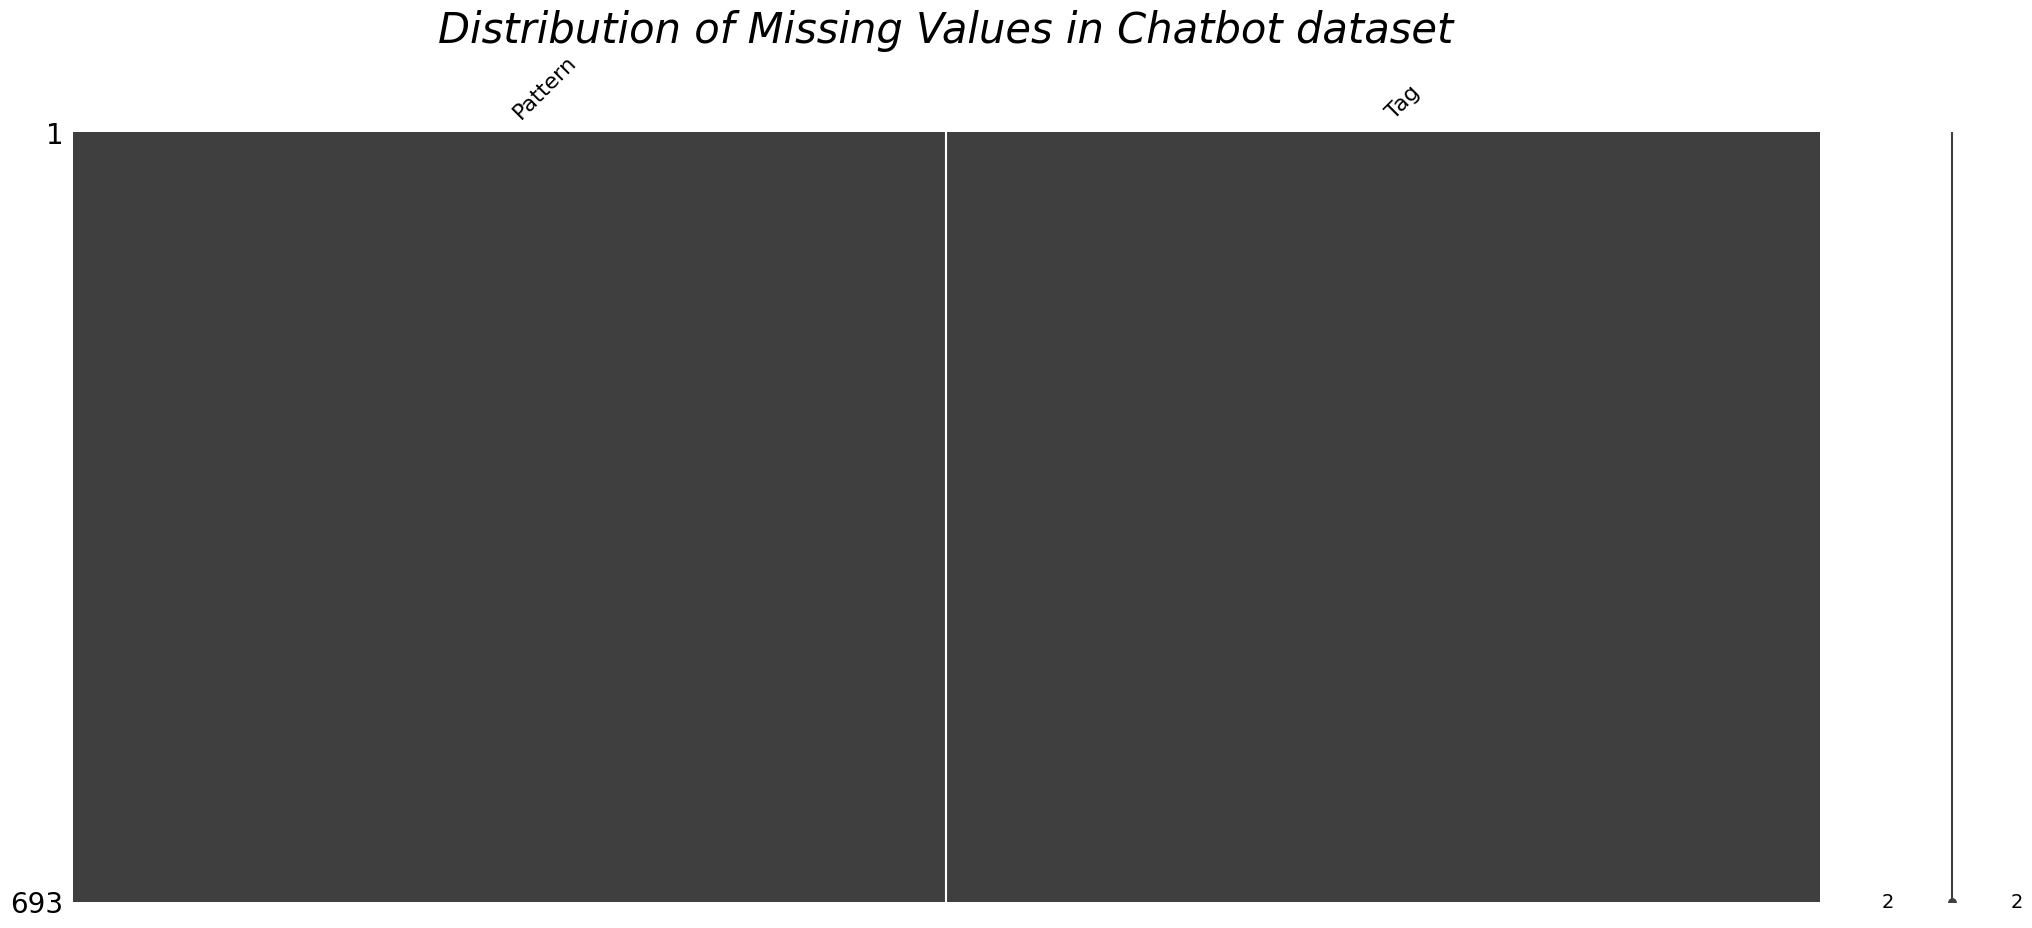

In [14]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

In [15]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

Total number of patterns associated with each tag


<ipython-input-15-63e4ac2f4c5f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)


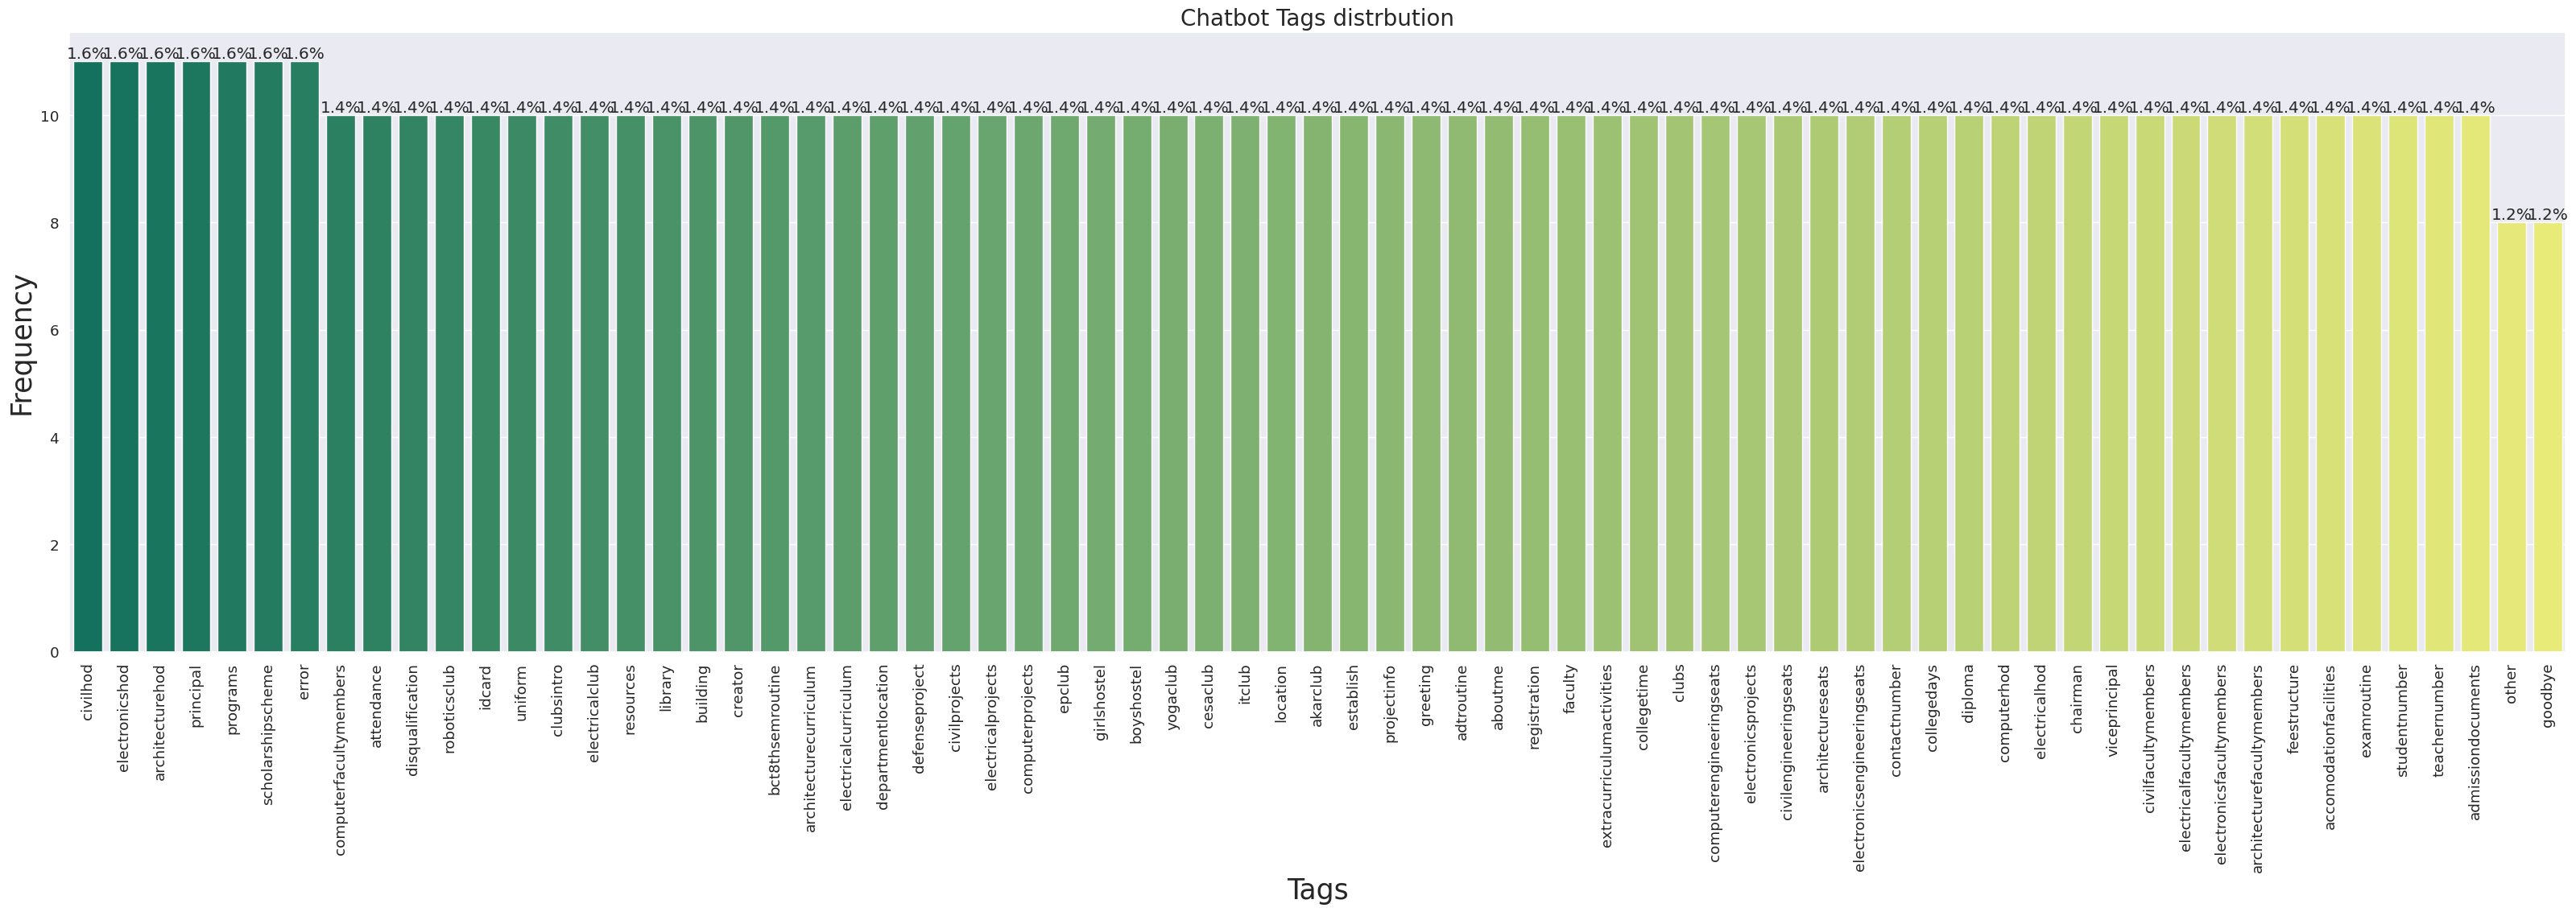

In [16]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 40,10, order=order,rotation=True, palette="summer")

In [17]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
import nltk

In [19]:
stemmer = PorterStemmer()

ignore_words=['?', '!', ',', '.']

with open("/content/drive/MyDrive/bert/nepali/NepaliStopWords.txt", "r", encoding="utf-8") as file:
    stop_words = set(line.strip() for line in file)

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    # Filter out stop words
    filtered_words = [word for word in words if word not in stop_words and word not in ignore_words]
    # Stem the remaining words
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    return " ".join(stemmed_words)


In [20]:
df.head()

,Pattern,Tag
0,नमस्कार,greeting
1,हेल्लो,greeting
2,नमस्ते,greeting
3,ओए,greeting
4,सुन,greeting


In [21]:
print(df["Pattern"])

0                                                नमस्कार
1                                                 हेल्लो
2                                                 नमस्ते
3                                                     ओए
4                                                    सुन
                             ...                        
688                           4thyear board exam routine
689    malai 4th year ko aba aaune parichya ko routin...
690    8th sem ko final exam ko routine pradan garnu ...
691                       board exam routine 8th sem bel
692            final parichya ko routine pradan garnuhos
Name: Pattern, Length: 693, dtype: object


In [22]:
print(df['Pattern'].isnull().sum())

0


In [23]:
# Plot count distribution
def plot_count_distribution(df, title, xlabel, ylabel, width=10, height=6):
    plt.figure(figsize=(width, height))
    sns.countplot(x='Tag', data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

In [24]:
# plt.figure(figsize=(20, 20))
# wc = WordCloud(font_path="/content/drive/MyDrive/bertmodel/nepali/Nepali.TTF", max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
# plt.imshow(wc, interpolation='bilinear')
# plt.xticks([])
# plt.yticks([])
# plt.show()


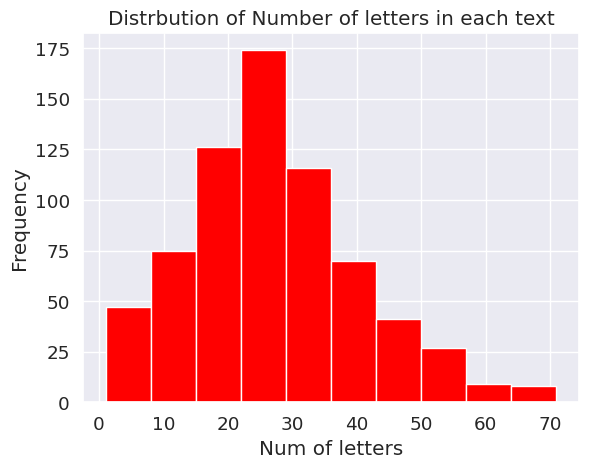

In [25]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

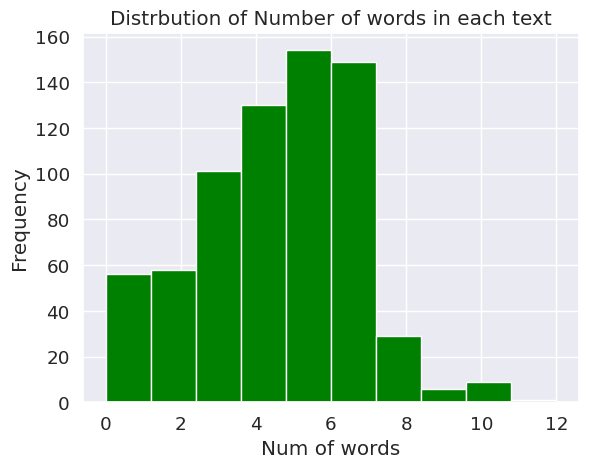

In [26]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-27-c5010b3a990f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color='red')


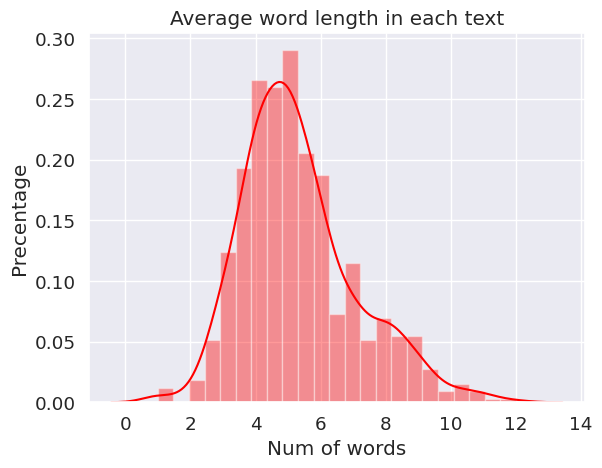

In [27]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [28]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['नमस्कार', 'हेल्लो', 'नमस्ते', 'ओए', 'सुन']

In [29]:
print(f"dataset contains {len(corpus)} words")

dataset contains 3086 words


In [30]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'ko': 131,
 'को': 88,
 'ma': 74,
 'के': 68,
 'kati': 67,
 'हो?': 51,
 'kec': 50,
 'k': 47,
 'कति': 44,
 'faculty': 41}

In [31]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2311 (\N{DEVANAGARI LETTER I}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas

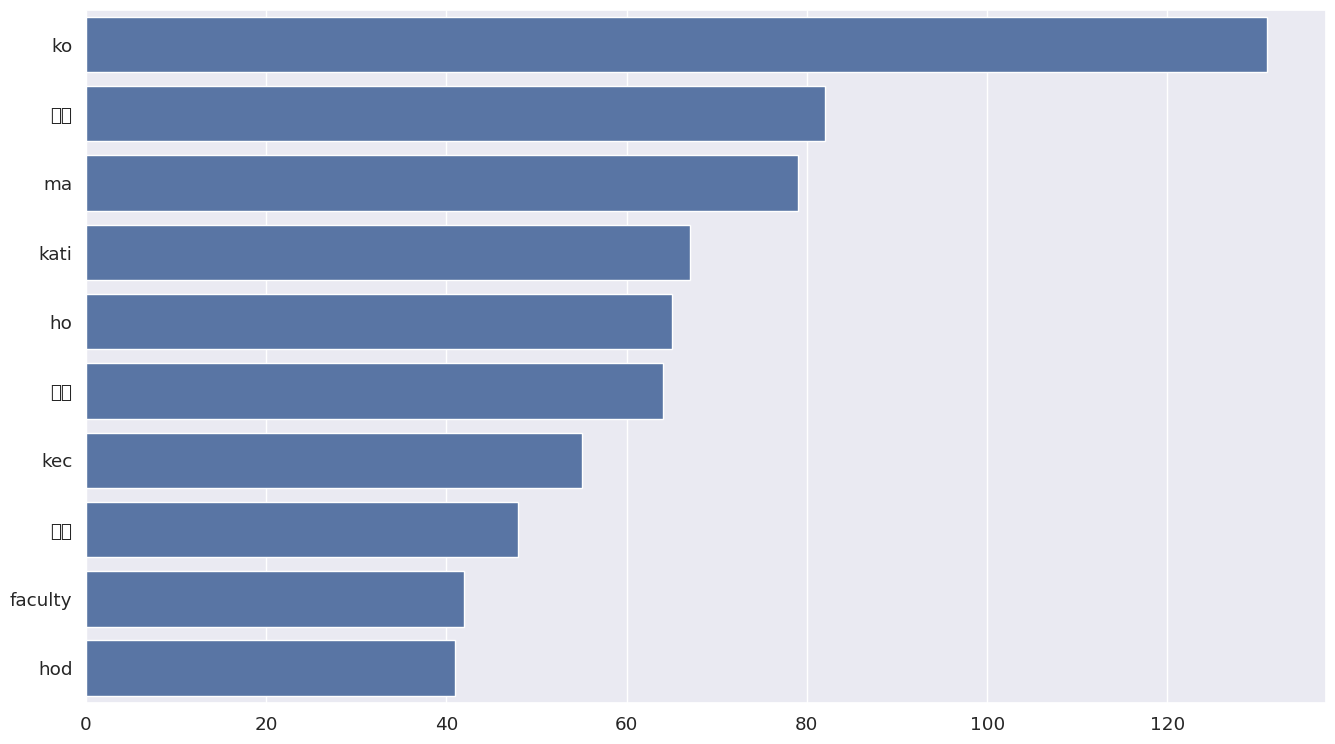

In [32]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

In [33]:
df2.head()

,Pattern,Tag
0,नमस्कार,greeting
1,हेल्लो,greeting
2,नमस्ते,greeting
3,ओए,greeting
4,सुन,greeting


In [34]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'location',
 'aboutme',
 'registration',
 'faculty',
 'extracurriculumactivities',
 'collegetime',
 'clubs',
 'programs',
 'error',
 'computerengineeringseats',
 'civilengineeringseats',
 'architectureseats',
 'electronicsengineeringseats',
 'contactnumber',
 'admissiondocuments',
 'other',
 'diploma',
 'computerhod',
 'electricalhod',
 'civilhod',
 'electronicshod',
 'architecturehod',
 'principal',
 'chairman',
 'viceprincipal',
 'civilfacultymembers',
 'electricalfacultymembers',
 'electronicsfacultymembers',
 'architecturefacultymembers',
 'feestructure',
 'scholarshipscheme',
 'accomodationfacilities',
 'collegedays',
 'studentnumber',
 'teachernumber',
 'establish',
 'creator',
 'building',
 'library',
 'resources',
 'computerfacultymembers',
 'attendance',
 'disqualification',
 'idcard',
 'uniform',
 'clubsintro',
 'electricalclub',
 'roboticsclub',
 'epclub',
 'akarclub',
 'itclub',
 'cesaclub',
 'yogaclub',
 'boyshostel',
 'girlshostel',
 'projectinfo

In [35]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [36]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'location',
 3: 'aboutme',
 4: 'registration',
 5: 'faculty',
 6: 'extracurriculumactivities',
 7: 'collegetime',
 8: 'clubs',
 9: 'programs',
 10: 'error',
 11: 'computerengineeringseats',
 12: 'civilengineeringseats',
 13: 'architectureseats',
 14: 'electronicsengineeringseats',
 15: 'contactnumber',
 16: 'admissiondocuments',
 17: 'other',
 18: 'diploma',
 19: 'computerhod',
 20: 'electricalhod',
 21: 'civilhod',
 22: 'electronicshod',
 23: 'architecturehod',
 24: 'principal',
 25: 'chairman',
 26: 'viceprincipal',
 27: 'civilfacultymembers',
 28: 'electricalfacultymembers',
 29: 'electronicsfacultymembers',
 30: 'architecturefacultymembers',
 31: 'feestructure',
 32: 'scholarshipscheme',
 33: 'accomodationfacilities',
 34: 'collegedays',
 35: 'studentnumber',
 36: 'teachernumber',
 37: 'establish',
 38: 'creator',
 39: 'building',
 40: 'library',
 41: 'resources',
 42: 'computerfacultymembers',
 43: 'attendance',
 44: 'disqualification',
 45: 'idc

In [37]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'location': 2,
 'aboutme': 3,
 'registration': 4,
 'faculty': 5,
 'extracurriculumactivities': 6,
 'collegetime': 7,
 'clubs': 8,
 'programs': 9,
 'error': 10,
 'computerengineeringseats': 11,
 'civilengineeringseats': 12,
 'architectureseats': 13,
 'electronicsengineeringseats': 14,
 'contactnumber': 15,
 'admissiondocuments': 16,
 'other': 17,
 'diploma': 18,
 'computerhod': 19,
 'electricalhod': 20,
 'civilhod': 21,
 'electronicshod': 22,
 'architecturehod': 23,
 'principal': 24,
 'chairman': 25,
 'viceprincipal': 26,
 'civilfacultymembers': 27,
 'electricalfacultymembers': 28,
 'electronicsfacultymembers': 29,
 'architecturefacultymembers': 30,
 'feestructure': 31,
 'scholarshipscheme': 32,
 'accomodationfacilities': 33,
 'collegedays': 34,
 'studentnumber': 35,
 'teachernumber': 36,
 'establish': 37,
 'creator': 38,
 'building': 39,
 'library': 40,
 'resources': 41,
 'computerfacultymembers': 42,
 'attendance': 43,
 'disqualification': 44,
 'idcard'

In [38]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,नमस्कार,greeting,0
1,हेल्लो,greeting,0
2,नमस्ते,greeting,0
3,ओए,greeting,0
4,सुन,greeting,0


In [39]:
X = list(df2['Pattern'])
X[:5]

['नमस्कार', 'हेल्लो', 'नमस्ते', 'ओए', 'सुन']

In [40]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [41]:
# Splitting data into train and test sets (80% train, 20% test)
X_train_test, X_temp, y_train_test, y_temp = train_test_split(X, y, test_size=0.2, random_state=123)

# Further splitting temp set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

# Further splitting train_test set into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.125, random_state=123) # 0.125 represents 10% of the original data

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 484
Validation size: 70
Test size: 70


In [42]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

484
70
484
70


In [43]:
model_name = "bert-base-multilingual-cased"
max_len = 256

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)
val_encoding = tokenizer(X_val, truncation = True, padding = True)

In [45]:
full_data = tokenizer(X, truncation=True, padding=True)

In [46]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [47]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)
val_dataloader = DataLoader(val_encoding, y_val)


In [48]:
fullDataLoader = DataLoader(full_data, y_test)

In [49]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [50]:
# pip install accelerate -U

In [51]:
# pip install transformers[torch]

In [52]:
# pip install accelerate>=0.21.0 -U

In [53]:
pip install wandb


Add early stopping

In [54]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=60,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    # weight_decay=0.05,
    # weight_decay=0.001,  # Adjust weight decay, experiment, 0.01
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True,
    learning_rate=4e-5,  # Adjust learning rate
)

In [55]:
import wandb


In [56]:
wandb.init(project="nepali2", config=training_args)


wandb: Currently logged in as: goldencloverr11. Use `wandb login --relogin` to force relogin


In [57]:
wandb.config.update(training_args.__dict__)


In [58]:
# !pip install pytorch-lightning

In [59]:
# from pytorch_lightning.callbacks import EarlyStoppingCallback

In [60]:
from transformers import EarlyStoppingCallback

In [61]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Training

In [62]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,4.220400,4.233325,0.000000,0.000000,0.000000,0.000000
100,3.903800,3.838048,0.142857,0.086064,0.083333,0.110169
150,3.020200,3.096900,0.300000,0.196798,0.209040,0.240113
200,2.006800,2.364221,0.571429,0.451190,0.468750,0.492560
250,1.195000,1.732714,0.700000,0.575000,0.587963,0.600309
300,0.649600,1.261583,0.785714,0.711111,0.735294,0.725490
350,0.336000,0.975185,0.785714,0.660667,0.663333,0.696667
400,0.170400,0.810209,0.814286,0.711333,0.730000,0.726667
450,0.100400,0.787239,0.800000,0.672000,0.673333,0.703333
500,0.071500,0.757190,0.800000,0.698445,0.710884,0.722789


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

TrainOutput(global_step=600, training_loss=1.3148679653803508, metrics={'train_runtime': 151.1809, 'train_samples_per_second': 192.088, 'train_steps_per_second': 6.35, 'total_flos': 289536620459112.0, 'train_loss': 1.3148679653803508, 'epoch': 37.5})

In [63]:
# from transformers import BertTokenizer, BertForSequenceClassification

# # Define paths to save tokenizer and model
# tokenizer_path = "/content/drive/MyDrive/bertmodel/nepali"
# model_path = "/content/drive/MyDrive/bertmodel/nepali"

# # Instantiate the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
# model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased")

# # Save the tokenizer
# tokenizer.save_pretrained(tokenizer_path)

# # Save the model
# model.save_pretrained(model_path)

In [64]:
# Access the training logs
# train_logs = trainer.state.log_history


In [74]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.049147,0.997934,0.997424,0.997101,0.998188
test,1.359993,0.714286,0.577564,0.599359,0.592949


In [75]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [67]:
# text = "Hello"
# predict(text)

In [76]:
model_path = "/content/drive/MyDrive/crazy/eng/modelcrazy"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/crazy/eng/modelcrazy/tokenizer_config.json',
 '/content/drive/MyDrive/crazy/eng/modelcrazy/special_tokens_map.json',
 '/content/drive/MyDrive/crazy/eng/modelcrazy/vocab.txt',
 '/content/drive/MyDrive/crazy/eng/modelcrazy/added_tokens.json',
 '/content/drive/MyDrive/crazy/eng/modelcrazy/tokenizer.json')

In [69]:
# !pip install xformers

In [77]:
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [78]:
chatbot("Hello")

[{'label': 'goodbye', 'score': 0.6967346668243408}]

In [79]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.5:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()

In [81]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


User: namaste
Chatbot: नमस्कार kec chatbot मा स्वागत छ। म तपाईलाई कसरी मद्दत् गर्नसक्छु?


User: kec kaha cha
Chatbot: काठमाडौं इन्जिनियरिङ कलेज कालीमाटी, काठमाडौंमा अवस्थित छ। थप जानकारीको लागि कृपया <a target="_blank" href="https://maps.app.goo.gl/CPpCvJfDe2wkCBr3A">Click</a> गर्नुहोस्।


User: architecture ko pathyakram
Chatbot: {'text': 'BArch Curriculam', 'table': {'headers': ['Year/Part', 'Subjects'], 'rows': [['I/I', 'SH 104 Mathematics for Acrchitecture I \nAR 101 Design Studio I \nAR 102 Introduction to Architecture \nAR 103 Building Material I \nAR 104 Architecture Graphics I \nAR 105 Free Hand Sketching I'], ['I/II', 'SH 155 Mathematics for Acrchitecture II \nAR 151 Architecture Graphics II \nAR 152 Design Studio II \nAR 153 Building Construction I \nAR 154 History of Nepalese Architecture \nAR 155 Free Hand Sketching II 